In [ ]:
%%capture
%pip install -r ../requirements.txt

In [2]:
from schema import WLD

wld = WLD(file_path="../data/example-chappy.wld")

In [3]:
# Get all exercises from all workouts
all_exercises = []
for workout in wld.workouts:
    all_exercises.extend(workout.exercises)
print(f"Total exercises: {len(all_exercises)}")

Total exercises: 8821


In [4]:
from collections import Counter

# Count exercise names and iterations, only for reps_weight exercises
exercise_counts = Counter()
for exercise in all_exercises:
    if exercise.style == "reps_weight":
        key = f"{exercise.iteration} {exercise.name}" if exercise.iteration else exercise.name
        exercise_counts[key] += 1

# Get top 50 most common exercises
top_50 = exercise_counts.most_common(50)

# Calculate total exercises in top 50
top_50_total = sum(count for _, count in top_50)
percent_of_total = (top_50_total / len(all_exercises)) * 100

print(f"Top 50 most popular weighted exercises (representing {top_50_total:,} exercises, {percent_of_total:.1f}% of total):")
for i, (name, count) in enumerate(top_50, 1):
    print(f"{i}. {name}: {count:,} times")

Top 50 most popular weighted exercises (representing 5,982 exercises, 67.8% of total):
1. Dumbbell Lateral Raises: 447 times
2. Flat Barbell Bench Press: 369 times
3. Hammer Curls: 321 times
4. One-arm Overhead Extensions: 296 times
5. Close-grip Bench Press: 268 times
6. Barbell Overhead Press: 259 times
7. Back Squats: 183 times
8. Concentration Curls: 181 times
9. Barbell Preacher Curls: 180 times
10. Incline Barbell Bench Press: 162 times
11. Dumbbell One-arm Rows: 161 times
12. Barbell Conventional Curls: 151 times
13. Dumbbell Conventional Curls: 144 times
14. Tricep Pushdowns: 128 times
15. Outer Hip Abductions: 128 times
16. Dumbbell Underhand Front Raises: 124 times
17. Normal Lat Pulldowns: 123 times
18. Machine Weighted Crunches: 118 times
19. Leg Extensions: 107 times
20. Sitting Leg Curls: 103 times
21. Dumbbell Preacher Curls: 102 times
22. Cable Reverse Flyes: 101 times
23. Cable Weighted Crunches: 93 times
24. Iso Lateral Overhead Press: 92 times
25. Band Reverse Flyes:

In [5]:
# Create a set of top 50 exercise names for faster lookup
top_50_exercises = {name for name, _ in top_50}

# Sort all exercises by date before processing PRs
all_exercises.sort(key=lambda x: x.workout().date)

current_one_rms = {}
current_volumes = {}

all_one_rm_prs = []
all_volume_prs = []

for exercise in all_exercises:
    if not exercise.style == "reps_weight":
        continue
    key = f"{exercise.iteration} {exercise.name}" if exercise.iteration else exercise.name
    if key not in top_50_exercises:
        continue
    one_rm = max([set.oneRM for set in exercise.sets])
    volume = sum([set.volume for set in exercise.sets])
    date = exercise.workout().date
    if one_rm > current_one_rms.get(key, 0):
        if key in current_one_rms:
            all_one_rm_prs.append((date, key, one_rm))
        current_one_rms[key] = one_rm
    if volume > current_volumes.get(key, 0):
        if key in current_volumes:
            all_volume_prs.append((date, key, volume))
        current_volumes[key] = volume

print(f"Total 1RM PRs recorded: {len(all_one_rm_prs):,}")
print(f"Total volume PRs recorded: {len(all_volume_prs):,}")

Total 1RM PRs recorded: 617
Total volume PRs recorded: 472


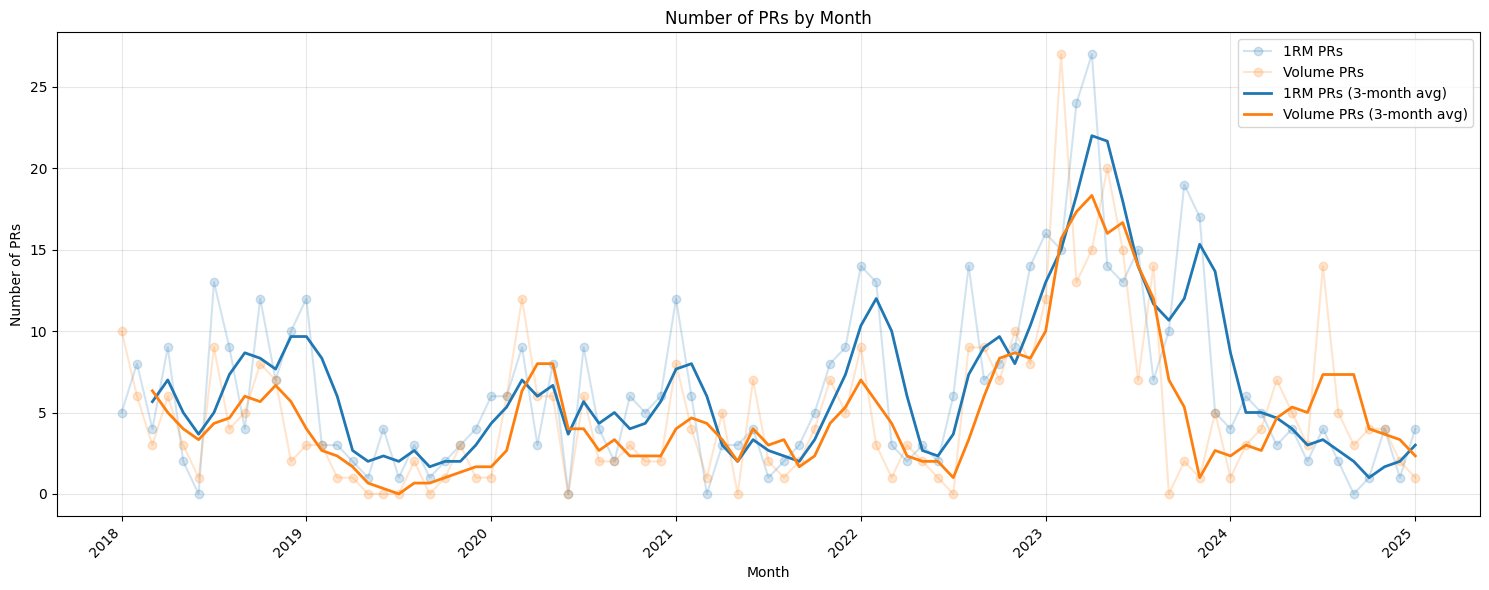

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from collections import defaultdict

# Create dictionaries to store PR counts by month
one_rm_prs_by_month = defaultdict(int)
volume_prs_by_month = defaultdict(int)

# Convert dates to month keys and count PRs
for date, _, _ in all_one_rm_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    one_rm_prs_by_month[month_key] += 1

for date, _, _ in all_volume_prs:
    if date.year < 2018:
        continue
    month_key = date.strftime("%Y-%m")
    volume_prs_by_month[month_key] += 1

# Generate all months between min and max dates
start_date = datetime(2018, 1, 1)
end_date = datetime.now()
all_months = pd.date_range(start_date, end_date, freq='MS').strftime("%Y-%m").tolist()

# Create lists for plotting
one_rm_counts = []
volume_counts = []

for month in all_months:
    one_rm_counts.append(one_rm_prs_by_month[month])
    volume_counts.append(volume_prs_by_month[month])

# Create the plot
plt.figure(figsize=(15, 6))

# Plot original lines with reduced opacity
line1, = plt.plot(all_months, one_rm_counts, label="1RM PRs", marker='o', alpha=0.2)
line2, = plt.plot(all_months, volume_counts, label="Volume PRs", marker='o', alpha=0.2)

# Calculate 3-month rolling averages
window_size = 3
one_rm_rolling = pd.Series(one_rm_counts).rolling(window=window_size).mean()
volume_rolling = pd.Series(volume_counts).rolling(window=window_size).mean()

plt.plot(all_months, one_rm_rolling, label="1RM PRs (3-month avg)", linewidth=2, color=line1.get_color())
plt.plot(all_months, volume_rolling, label="Volume PRs (3-month avg)", linewidth=2, color=line2.get_color())

# Customize the plot
plt.title("Number of PRs by Month")
plt.xlabel("Month")
plt.ylabel("Number of PRs")

# Show x-axis labels for Jan 1 of each year
tick_positions = []
tick_labels = []
for i, month in enumerate(all_months):
    year, month = month.split('-')
    if month == '01':  # January only
        tick_positions.append(i)
        tick_labels.append(f"{year}")

plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()